# Multi-Class Deep Learning Model for AIR Lab iBeans Using TensorFlow Take 2
### David Lowe
### September 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The AIR Lab iBeans dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset is of leaf images taken in the field in different districts in Uganda by the Makerere AI lab in collaboration with the National Crops Resources Research Institute (NaCRRI), the national body in charge of research in agriculture in Uganda.

The goal is to build a robust machine learning model that can distinguish between diseases in the Bean plants. The data is of leaf images representing three classes: the healthy images and two disease classes, including Angular Leaf Spot and Bean Rust diseases. The model should be able to distinguish between these three classes with high accuracy. The end goal is to build a model that can be deployed on a mobile device and used in the field by a farmer.

From iteration Take1, we constructed and tuned machine learning models for this dataset using TensorFlow with a simple VGG-5 network. We also observed the best result that we could obtain using the validation and test datasets. The final output from this iteration became our baseline performance level for future iterations.

In this Take2 iteration, we will construct and tune machine learning models for this dataset using a simple VGG-5 network with dropout regularizations of 0.2 for the convolution layers and 0.5 for the fully-connected layers. The original VGG research paper inspired the dropout layers and ratios. We will observe the best result that we can obtain using the validation and test datasets. The final output from this iteration will become our baseline performance level for future iterations.

ANALYSIS: From iteration Take1, the performance of the baseline model achieved an accuracy score of 75.94% on the validation dataset after 50 epochs. Furthermore, the same baseline processed the test dataset with an accuracy score of 82.03%.

From iteration Take2, the performance of the baseline model achieved an accuracy score of 80.45% on the validation dataset after 100 epochs. Furthermore, the same baseline processed the test dataset with an accuracy score of 85.16%.

CONCLUSION: For this dataset, the model built using TensorFlow with VGG-5 blocks performed adequately with the image datasets. However, we should consider tuning the model further by using image augmentation and regularization techniques.

Dataset Used: AIR Lab iBeans Dataset

Dataset ML Model: Multi-classification with numerical attributes

Dataset Reference: https://github.com/AI-Lab-Makerere/ibean/

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 2.8MB/s 


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Sep  1 03:08:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [5]:
# Direct Colab to use TensorFlow v2
%tensorflow_version 2.x

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import os
import sys
import zipfile
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from dotenv import load_dotenv
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 100
default_batch = 16
target_image_size = (500, 500)
default_input_shape = (500, 500, 3)
num_class = 3

# Define the labels to use for graphing the data
train_metric = "accuracy"
train_loss = "loss"

Num GPUs Available:  1


In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [12]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [13]:
!rm -rf image/
!rm train.zip
!rm validation.zip
!rm test.zip

rm: cannot remove 'train.zip': No such file or directory
rm: cannot remove 'validation.zip': No such file or directory
rm: cannot remove 'test.zip': No such file or directory


In [14]:
image_dir = 'image/'
!mkdir image/

In [15]:
!wget https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/train.zip

--2020-09-01 03:08:27--  https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/train.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.89.19, 13.225.89.16, 13.225.89.125, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.89.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M   171MB/s    in 0.8s    

2020-09-01 03:08:28 (171 MB/s) - ‘train.zip’ saved [143812152/143812152]



In [16]:
!wget https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/validation.zip

--2020-09-01 03:08:28--  https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/validation.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.115.51, 13.226.115.71, 13.226.115.45, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.115.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================>]  17.65M  86.3MB/s    in 0.2s    

2020-09-01 03:08:29 (86.3 MB/s) - ‘validation.zip’ saved [18504213/18504213]



In [17]:
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_dir)
local_zip = 'validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_dir)
zip_ref.close()

In [18]:
train_spot_dir = os.path.join(image_dir, 'train/angular_leaf_spot')
train_rust_dir = os.path.join(image_dir, 'train/bean_rust')
train_healthy_dir = os.path.join(image_dir, 'train/healthy')

print('total training angular leaf spot images:', len(os.listdir(train_spot_dir)))
print('total training bean rust images:', len(os.listdir(train_rust_dir)))
print('total training healthy images:', len(os.listdir(train_healthy_dir)))

train_spot_files = os.listdir(train_spot_dir)
print(train_spot_files[:10])

train_rust_files = os.listdir(train_rust_dir)
print(train_rust_files[:10])

train_healthy_files = os.listdir(train_healthy_dir)
print(train_healthy_files[:10])

total training angular leaf spot images: 345
total training bean rust images: 348
total training healthy images: 342
['angular_leaf_spot_train.180.jpg', 'angular_leaf_spot_train.87.jpg', 'angular_leaf_spot_train.254.jpg', 'angular_leaf_spot_train.149.jpg', 'angular_leaf_spot_train.276.jpg', 'angular_leaf_spot_train.170.jpg', 'angular_leaf_spot_train.36.jpg', 'angular_leaf_spot_train.118.jpg', 'angular_leaf_spot_train.344.jpg', 'angular_leaf_spot_train.299.jpg']
['bean_rust_train.160.jpg', 'bean_rust_train.129.jpg', 'bean_rust_train.272.jpg', 'bean_rust_train.316.jpg', 'bean_rust_train.92.jpg', 'bean_rust_train.138.jpg', 'bean_rust_train.306.jpg', 'bean_rust_train.156.jpg', 'bean_rust_train.17.jpg', 'bean_rust_train.40.jpg']
['healthy_train.192.jpg', 'healthy_train.193.jpg', 'healthy_train.176.jpg', 'healthy_train.324.jpg', 'healthy_train.46.jpg', 'healthy_train.257.jpg', 'healthy_train.268.jpg', 'healthy_train.238.jpg', 'healthy_train.10.jpg', 'healthy_train.65.jpg']


In [19]:
validation_spot_dir = os.path.join(image_dir, 'validation/angular_leaf_spot')
validation_rust_dir = os.path.join(image_dir, 'validation/bean_rust')
validation_healthy_dir = os.path.join(image_dir, 'validation/healthy')

print('total validation angular leaf spot images:', len(os.listdir(validation_spot_dir)))
print('total validation bean rust images:', len(os.listdir(validation_rust_dir)))
print('total validation healthy images:', len(os.listdir(validation_healthy_dir)))

validation_spot_files = os.listdir(validation_spot_dir)
print(validation_spot_files[:10])

validation_rust_files = os.listdir(validation_rust_dir)
print(validation_rust_files[:10])

validation_healthy_files = os.listdir(validation_healthy_dir)
print(validation_healthy_files[:10])

total validation angular leaf spot images: 44
total validation bean rust images: 45
total validation healthy images: 44
['angular_leaf_spot_val.26.jpg', 'angular_leaf_spot_val.5.jpg', 'angular_leaf_spot_val.27.jpg', 'angular_leaf_spot_val.8.jpg', 'angular_leaf_spot_val.30.jpg', 'angular_leaf_spot_val.37.jpg', 'angular_leaf_spot_val.13.jpg', 'angular_leaf_spot_val.16.jpg', 'angular_leaf_spot_val.21.jpg', 'angular_leaf_spot_val.39.jpg']
['bean_rust_val.38.jpg', 'bean_rust_val.34.jpg', 'bean_rust_val.23.jpg', 'bean_rust_val.0.jpg', 'bean_rust_val.30.jpg', 'bean_rust_val.42.jpg', 'bean_rust_val.24.jpg', 'bean_rust_val.26.jpg', 'bean_rust_val.15.jpg', 'bean_rust_val.1.jpg']
['healthy_val.34.jpg', 'healthy_val.38.jpg', 'healthy_val.24.jpg', 'healthy_val.25.jpg', 'healthy_val.17.jpg', 'healthy_val.32.jpg', 'healthy_val.35.jpg', 'healthy_val.30.jpg', 'healthy_val.7.jpg', 'healthy_val.20.jpg']


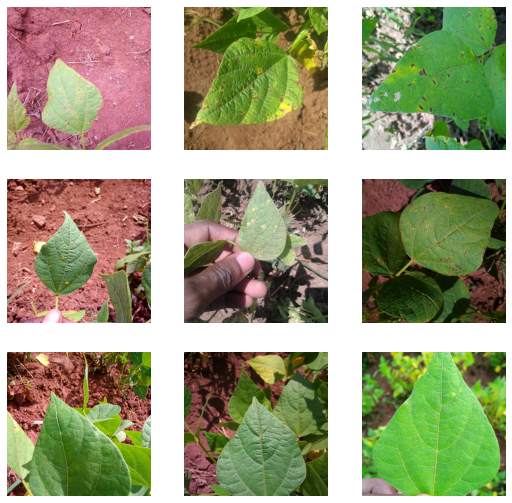

In [20]:
# Plot some training images from the dataset
# Parameters for our graph; we'll output images in a 3x3 configuration
nrows = 3
ncols = 3

# Index for iterating over images
pic_index = 3

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

next_spot = [os.path.join(train_spot_dir, fname) 
                for fname in train_spot_files[pic_index-3:pic_index]]
next_rust = [os.path.join(train_rust_dir, fname) 
                for fname in train_rust_files[pic_index-3:pic_index]]
next_healthy = [os.path.join(train_healthy_dir, fname) 
                for fname in train_healthy_files[pic_index-3:pic_index]]

for i, img_path in enumerate(next_spot + next_rust + next_healthy):
	# Set up subplot; subplot indices start at 1
	sp = plt.subplot(nrows, ncols, i + 1)
	sp.axis('Off') # Don't show axes (or gridlines)
	img = mpimg.imread(img_path)
	plt.imshow(img)

plt.show()

In [21]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [22]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [24]:
# Flow training images in batches using train_datagen generator
train_dir = "image/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_image_size,
        batch_size=default_batch,
        class_mode='categorical')
print('Number of image batches per epoch of modeling', len(train_generator))

Found 1034 images belonging to 3 classes.
Number of image batches per epoch of modeling 65


In [25]:
# Flow training images in batches using validation_datagen generator
validation_dir = "image/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_image_size,
        batch_size=default_batch,
        class_mode='categorical')
print('Number of image batches per epoch of modeling', len(validation_generator))

Found 133 images belonging to 3 classes.
Number of image batches per epoch of modeling 9


In [26]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=32, conv2_filters=64, conv3_filters=128, conv4_filters=256, conv5_filters=256,
                    dense_nodes1=512, dense_nodes2=512, dense_nodes3=128, conv_dropout=0.2, dense_dropout=0.5,
                    opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=default_input_shape),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        keras.layers.Dropout(conv_dropout),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        keras.layers.Dropout(conv_dropout),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        keras.layers.Dropout(conv_dropout),
        # This is the fourth convolution
        keras.layers.Conv2D(conv4_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv4_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        keras.layers.Dropout(conv_dropout),
        # This is the fifth convolution
        keras.layers.Conv2D(conv5_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv5_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        keras.layers.Dropout(conv_dropout),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes1, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(dense_nodes2, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(dense_nodes3, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(num_class, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [27]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/100
65/65 [==============================] - 13s 198ms/step - loss: 1.1021 - accuracy: 0.3211 - val_loss: 1.0984 - val_accuracy: 0.4361
Epoch 2/100
65/65 [==============================] - 12s 190ms/step - loss: 1.0973 - accuracy: 0.3578 - val_loss: 1.0981 - val_accuracy: 0.3835
Epoch 3/100
65/65 [==============================] - 12s 188ms/step - loss: 1.0993 - accuracy: 0.3375 - val_loss: 1.0979 - val_accuracy: 0.3383
Epoch 4/100
65/65 [==============================] - 12s 187ms/step - loss: 1.0952 - accuracy: 0.3588 - val_loss: 1.0975 - val_accuracy: 0.3233
Epoch 5/100
65/65 [==============================] - 12s 185ms/step - loss: 1.0951 - accuracy: 0.3675 - val_loss: 1.0976 - val_accuracy: 0.3383
Epoch 6/100
65/65 [==============================] - 12s 186ms/step - loss: 1.0911 - accuracy: 0.3723 - val_loss: 1.0962 - val_accuracy: 0.3383
Epoch 7/100
65/65 [==============================] - 12s 185ms/step - loss: 1.0897 - accuracy: 0.3781 - val_loss: 1.0972 - val_accuracy:

In [28]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 128)     7

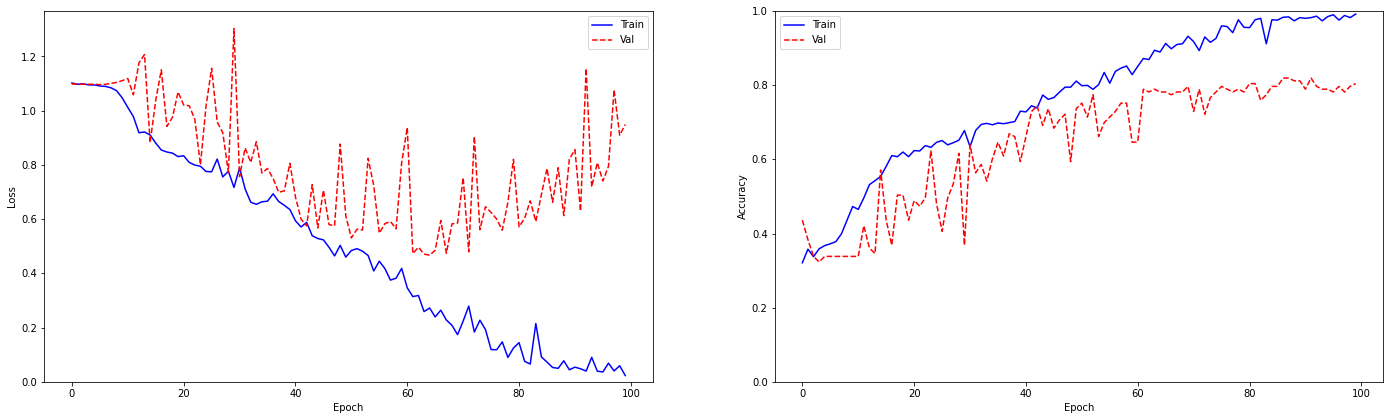

In [29]:
plot_metrics(baseline_history)

In [30]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [31]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [32]:
# Not applicable for this iteration of modeling

In [33]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [34]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
!wget https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/test.zip

--2020-09-01 03:29:13--  https://dainesanalytics.com/datasets/tensorflow-air-lab-ibeans/test.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.225.89.19, 13.225.89.16, 13.225.89.26, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.225.89.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17708541 (17M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  16.89M  77.2MB/s    in 0.2s    

2020-09-01 03:29:14 (77.2 MB/s) - ‘test.zip’ saved [17708541/17708541]



In [36]:
local_zip = 'test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_dir)
zip_ref.close()

In [37]:
test_spot_dir = os.path.join(image_dir, 'test/angular_leaf_spot')
test_rust_dir = os.path.join(image_dir, 'test/bean_rust')
test_healthy_dir = os.path.join(image_dir, 'test/healthy')

print('total test angular leaf spot images:', len(os.listdir(test_spot_dir)))
print('total test bean rust images:', len(os.listdir(test_rust_dir)))
print('total test healthy images:', len(os.listdir(test_healthy_dir)))

test_spot_files = os.listdir(test_spot_dir)
print(test_spot_files[:10])

test_rust_files = os.listdir(test_rust_dir)
print(test_rust_files[:10])

test_healthy_files = os.listdir(test_healthy_dir)
print(test_healthy_files[:10])

total test angular leaf spot images: 43
total test bean rust images: 43
total test healthy images: 42
['angular_leaf_spot_test.6.jpg', 'angular_leaf_spot_test.32.jpg', 'angular_leaf_spot_test.8.jpg', 'angular_leaf_spot_test.0.jpg', 'angular_leaf_spot_test.24.jpg', 'angular_leaf_spot_test.21.jpg', 'angular_leaf_spot_test.20.jpg', 'angular_leaf_spot_test.7.jpg', 'angular_leaf_spot_test.36.jpg', 'angular_leaf_spot_test.40.jpg']
['bean_rust_test.38.jpg', 'bean_rust_test.9.jpg', 'bean_rust_test.22.jpg', 'bean_rust_test.28.jpg', 'bean_rust_test.12.jpg', 'bean_rust_test.31.jpg', 'bean_rust_test.16.jpg', 'bean_rust_test.33.jpg', 'bean_rust_test.2.jpg', 'bean_rust_test.18.jpg']
['healthy_test.25.jpg', 'healthy_test.31.jpg', 'healthy_test.26.jpg', 'healthy_test.38.jpg', 'healthy_test.3.jpg', 'healthy_test.9.jpg', 'healthy_test.20.jpg', 'healthy_test.32.jpg', 'healthy_test.40.jpg', 'healthy_test.14.jpg']


In [38]:
# Flow training images in batches using train_datagen generator
test_dir = "image/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_image_size,
        batch_size=default_batch,
        class_mode='categorical')
print('Number of image batches per epoch of modeling', len(test_generator))

Found 128 images belonging to 3 classes.
Number of image batches per epoch of modeling 8


In [39]:
# Check the performance of the model using the test dataset
baseline_model.evaluate(test_generator, verbose=1)

8/8 [==============================] - 1s 135ms/step - loss: 0.7860 - accuracy: 0.8516


[0.7859667539596558, 0.8515625]

In [40]:
if (notifyStatus): status_notify("Phase 5 Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:20:50.692267
